In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (train_test_split,
                                     GridSearchCV,
)
from sklearn.metrics import (roc_curve,
                             average_precision_score,
                             roc_auc_score,
                             brier_score_loss,
)
from lightgbm import LGBMClassifier
import optuna.integration.lightgbm as lgb
import optuna
from preprocessing import preprocess

/Users/clundberg/.local/share/virtualenvs/loan-default-EfrBu0lz/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preprocess Data

In [2]:
df = pd.read_csv('data/accepted_2007_to_2018Q4.csv')
df = preprocess(df)
df.dropna(inplace=True)

X, y = df.drop("loan_status", axis=1), df["loan_status"]
cols = [col for col in X.columns if X[col].dtype == "float64"]
X = X[cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1, stratify=y_train)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled, X_val_scaled = scaler.transform(X_train), scaler.transform(X_val)

/var/folders/cb/pwqg37_d6zl28q9nq70dkfzw0000gn/T/ipykernel_67018/3480117357.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/accepted_2007_to_2018Q4.csv')
/Users/clundberg/Development/loan-default/preprocessing.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["earliest_cr_line"] = pd.to_datetime(df["earliest_cr_line"]).dt.year.astype(int)


## Train Baseline Classifiers

In this section, two baseline models are trained:

* `Logistic Regression`
* `Gradient Boosting Machine`

In [3]:
lr_clf = LogisticRegression(random_state=0)
lr_clf.fit(X_train_scaled, y_train)
y_preds = lr_clf.predict_proba(X_val_scaled)
fpr, tpr, _ = roc_curve(y_val, y_preds[:, 1], pos_label="Fully Paid")
lr_results = pd.DataFrame({"Brier Score": [brier_score_loss(y_val, y_preds[:, 1], pos_label="Fully Paid")], 
                           "AUC": [roc_auc_score(y_val, y_preds[:, 1])],
                           "AUC-PR": [average_precision_score(y_val, y_preds[:, 1], pos_label="Fully Paid")], 
                           "Model": ["Logistic Regression"]})
lr_roc_curve = pd.DataFrame({"False Positive Rate": fpr, "True Positive Rate": tpr, 
                           "Model": ["Logistic Regression"] * len(fpr)})

In [4]:
# Baseline GBM Classifier
gbm = LGBMClassifier(is_unbalance=True)
gbm.fit(X_train, y_train)
y_preds = gbm.predict_proba(X_val)
fpr, tpr, _ = roc_curve(y_val, y_preds[:, 1], pos_label="Fully Paid")
gbm_results = pd.DataFrame({"Brier Score": [brier_score_loss(y_val, y_preds[:, 1], pos_label="Fully Paid")], 
                           "AUC": [roc_auc_score(y_val, y_preds[:, 1])],
                           "AUC-PR": [average_precision_score(y_val, y_preds[:, 1], pos_label="Fully Paid")], 
                           "Model": ["Gradient Boosting Machine"]})
gbm_roc_curve = pd.DataFrame({"False Positive Rate": fpr, "True Positive Rate": tpr, "Model": ["Gradient Boosting Machine"] * len(fpr)})
results = pd.concat((lr_results, gbm_results), axis=0)
roc_curves = pd.concat((lr_roc_curve, gbm_roc_curve), axis=0)
results.round(2)

[LightGBM] [Info] Number of positive: 616993, number of negative: 150752
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1991
[LightGBM] [Info] Number of data points in the train set: 767745, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.803643 -> initscore=1.409222
[LightGBM] [Info] Start training from score 1.409222


,Brier Score,AUC,AUC-PR,Model
0,0.15,0.70,0.90,Logistic Regression
0,0.22,0.71,0.91,Gradient Boosting Machine


<Axes: xlabel='False Positive Rate', ylabel='True Positive Rate'>

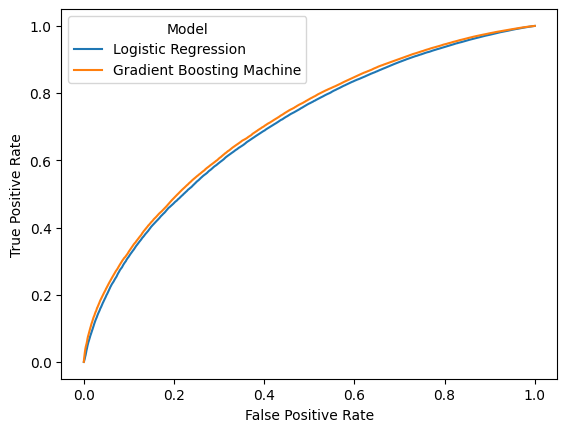

In [5]:
sns.lineplot(data=roc_curves, x="False Positive Rate", y="True Positive Rate", hue="Model", errorbar=None)

## Hyperparameter Optimization

In [16]:
# Use Optuna for HPO
# Try auc and average_precision_score for metrics
study = optuna.create_study(direction='maximize', study_name='lgb_tuning')

dtrain = lgb.Dataset(np.array(X_train), label=np.where(y_train == "Fully Paid", 1, 0))
dval = lgb.Dataset(np.array(X_val), label=np.where(y_val == "Fully Paid", 1, 0))

params = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",     
        "learning_rate": 0.01,           
        "seed": 42
    }

tuner = lgb.LightGBMTuner(params, 
                          train_set=dtrain, 
                          valid_sets=dval,
                          study=study,   
                          time_budget=300,                        
                          num_boost_round=1000)

tuner.run()

[I 2024-07-29 14:27:02,419] A new study created in memory with name: lgb_tuning
  0%|          | 0/5 [00:00<?, ?it/s]
